In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib import pyplot as pyplt


In [44]:
def dateparse(val):
    try:
        return pd.datetime.strptime(val, '%Y-%m-%dT%H:%M:%S').date()
    except:
        return pd.NaT
    
def standard_data_import(only_cs=True):
    df = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/wCfP_data_full_new.csv',
                     parse_dates=['startEvent', 'subDL', 'absRegDue', 'finVersDue', 'noteDue', 'endEvent'],
                     date_parser=dateparse, index_col='eventID')

    if only_cs:
        df_cs = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/wCfP_cs_automatic_labels.csv', index_col='eventID')
        df = df_cs.join(df, how='inner')
        return df[df.csLabel == 1]
    else:
        return df

In [45]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)


data = standard_data_import(only_cs=True)
data = data.reindex(columns=['year', 'text_length'])

# adding labels
df_pred_labels = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/predatory_conferences_2.csv', sep=';', index_col='eventID')
df_pred_labels = df_pred_labels.drop(['way_of_identification'], axis=1)
df_good_labels = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/wCfP_with_dim_citations_full_3.csv', index_col='eventID')
df_good_labels = df_good_labels[(df_good_labels.similarity >= 0.95) & (df_good_labels.citations > 10)]
df_good_labels = df_good_labels.reindex(columns=['citations', 'fcr', 'papers'])

data = data.join(df_pred_labels)
data = data.join(df_good_labels)

# predatory column comes from df_pred_labels and only positive ones must be added
for idx in data.index:
    if np.isnan(data.at[idx, 'predatory']):
        if data.at[idx, 'citations'] >= 10:
            data.at[idx, 'predatory'] = 0

# adding features
df_touristic = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/touristic_focus.csv', index_col='eventID')
df_tld = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/url_tld.csv', index_col='eventID')
df_adjective = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/adjective_percent1.csv', index_col='eventID')
df_duration = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/duration_days.csv', index_col='eventID')
df_suspicious = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/suspicious_words.csv', index_col='eventID')
df_committee = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/committee_info_full.csv', index_col='eventID')
df_conf_series = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/confSeries_citation.csv', index_col='eventID')
df_who_is_info = pd.read_csv('/Users/soumya/PycharmProjects/QualityConferences/data/whois_processed.csv', index_col='eventID')


data = data.join(df_touristic)
data = data.join(df_tld)
data = data.join(df_adjective)
data = data.join(df_duration)
data = data.join(df_suspicious)
data = data.join(df_committee)
data = data.join(df_conf_series)
data = data.join(df_who_is_info)
print('Missing values in data')
print(data.isna().sum())
print(data.columns)

data['tld'] = data['tld'].replace(np.nan, '')
data['trusted_tld'] = data['trusted_tld'].replace(np.nan, 0)
data['neg_duration'] = data['neg_duration'].replace(np.nan, 0)
data['start_subDl_duration_days'] = data['start_subDl_duration_days'].replace(np.nan, data['start_subDl_duration_days'].mean())
data['touristic_focus'] = data['touristic_focus'].replace(np.nan, 0)
data['private_registration'] = data['private_registration'].replace(np.nan, 0)
data['identity_hidden'] = data['identity_hidden'].replace(np.nan, 0)
data['completeness'] = data['completeness'].replace(np.nan, 0)
data['conf_series_citation'] = data['conf_series_citation'].replace(np.nan, 0)
data['geo_loc_diff_whois_loc'] = data['geo_loc_diff_whois_loc'].replace("True", 1)
data['geo_loc_diff_whois_loc'] = data['geo_loc_diff_whois_loc'].replace("False", 0)

for index, row in data.iterrows():
    if row['committee_number'] != 0:
        data.at[index, 'avg_cit_per_person'] = row['total_committee_avg_citation']/row['committee_number']
    else:
        data.at[index, 'avg_cit_per_person'] = 0

# test data must be split from full data based on labeling
train = data.dropna(subset=['predatory'])
test = data[pd.isnull(data['predatory'])]

train = train.astype({'predatory': 'int32'})
print(train.shape)
print(train.head())
print('Missing values in train data')
print(train.isna().sum())

Missing values in data
year                              158
text_length                         0
predatory                       40624
citations                       42143
fcr                             42143
papers                          42143
touristic_focus                  3422
website                           981
tld                                 6
trusted_tld                       981
adj_percent                         0
start_subDl_duration_days        2357
neg_duration                     2357
suspicious_words_count              0
suspicious_words_percentage         0
suspicious_words_found              0
committeeNames                   3422
committee_number                 3422
total_committee_citation         3422
total_committee_publications     3422
total_committee_avg_citation     3422
confSer_adjusted                26338
confSer_adjusted_sim            34083
older_conferences                3454
conf_series_citation             3454
private_registration       

In [46]:
train.columns

Index(['year', 'text_length', 'predatory', 'citations', 'fcr', 'papers', 'touristic_focus', 'website', 'tld', 'trusted_tld', 'adj_percent', 'start_subDl_duration_days', 'neg_duration', 'suspicious_words_count', 'suspicious_words_percentage', 'suspicious_words_found', 'committeeNames', 'committee_number', 'total_committee_citation', 'total_committee_publications', 'total_committee_avg_citation', 'confSer_adjusted', 'confSer_adjusted_sim', 'older_conferences', 'conf_series_citation', 'private_registration', 'geo_na_eu', 'geo_asia', 'whois_na_eu', 'whois_asia', 'geo_loc_diff_whois_loc', 'website_age', 'identity_hidden', 'completeness', 'avg_cit_per_person'], dtype='object')

In [47]:
# Replace conference citation data with zero
train['citations'] = train['citations'].replace(np.nan, 0)
train['fcr'] = train['fcr'].replace(np.nan, 0)
train['papers'] = train['papers'].replace(np.nan, 0)
train['confSer_adjusted'] = train['confSer_adjusted'].replace(np.nan, 0)

In [48]:
# Only extract usable features
train = train.reindex(columns=['touristic_focus', 'text_length', 'trusted_tld', 'adj_percent', 'suspicious_words_count',
                                                      'start_subDl_duration_days', 'neg_duration', 'committee_number', 'total_committee_citation',
                                                      'total_committee_publications', 'total_committee_avg_citation', 'avg_cit_per_person',
                                                      'conf_series_citation', 'private_registration', 'identity_hidden', 'completeness',
                                                      'geo_na_eu', 'geo_asia', 'whois_na_eu', 'whois_asia', 'geo_loc_diff_whois_loc',
                                                      'website_age', 'confSer_adjusted', 'predatory', 'citations', 'fcr'])

In [49]:
print(train.head())

         touristic_focus  text_length  trusted_tld  adj_percent  suspicious_words_count  start_subDl_duration_days  neg_duration  committee_number  total_committee_citation  total_committee_publications  total_committee_avg_citation  avg_cit_per_person  conf_series_citation  private_registration  identity_hidden  completeness  geo_na_eu  geo_asia  whois_na_eu  whois_asia geo_loc_diff_whois_loc  website_age  confSer_adjusted  predatory  citations  fcr
eventID                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1101                 0.0          186          0.0        12.50                       0   

Text(0,0.5,'Number of conferences')

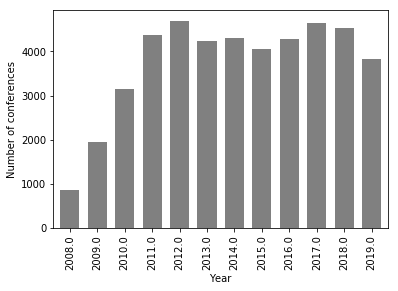

In [50]:
# Conferences over the years
ax = data['year'].value_counts(sort=False).plot(kind='bar', width=0.7, color='grey')
ax.set_xlabel("Year")
ax.set_ylabel("Number of conferences")

In [51]:
# Extracting predatory and good sonferences
train_pred = train[train['predatory'] == 1]
print(train_pred.shape)
train_good = train[train['predatory'] == 0]
print(train_good.shape)

(1548, 26)
(2901, 26)


Index(['touristic_focus', 'text_length', 'trusted_tld', 'adj_percent', 'suspicious_words_count', 'start_subDl_duration_days', 'neg_duration', 'committee_number', 'total_committee_citation', 'total_committee_publications', 'total_committee_avg_citation', 'avg_cit_per_person', 'conf_series_citation', 'private_registration', 'identity_hidden', 'completeness', 'geo_na_eu', 'geo_asia', 'whois_na_eu', 'whois_asia', 'geo_loc_diff_whois_loc', 'website_age', 'confSer_adjusted', 'predatory', 'citations', 'fcr'], dtype='object')


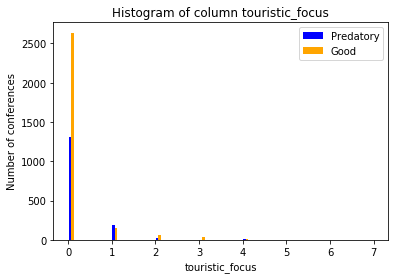

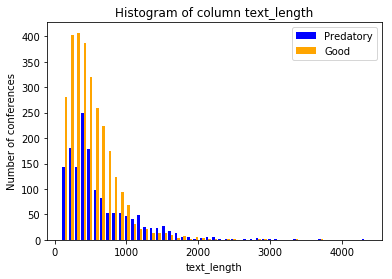

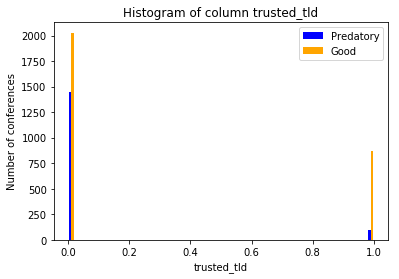

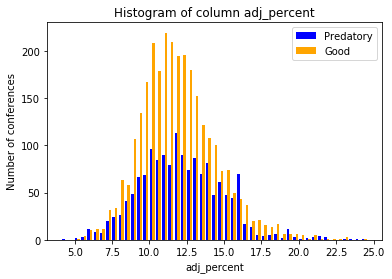

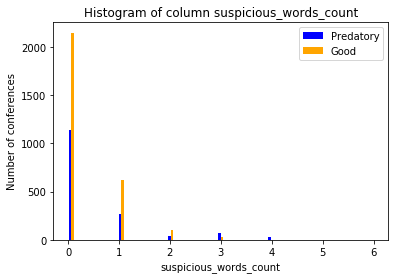

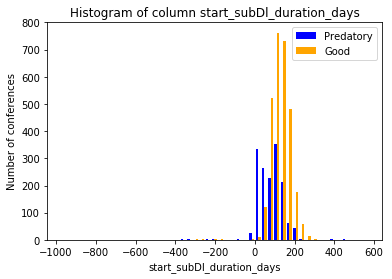

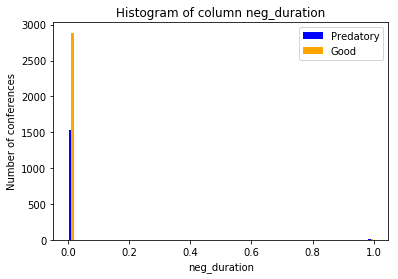

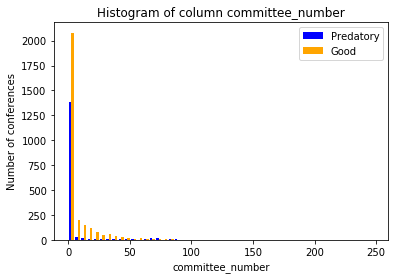

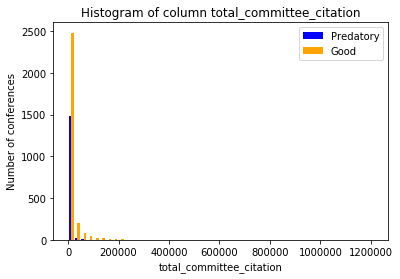

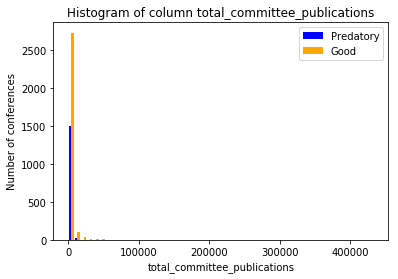

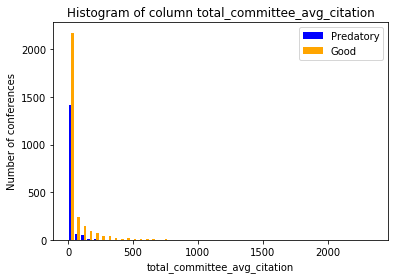

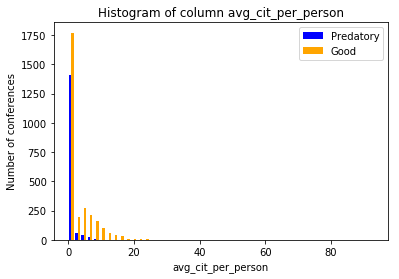

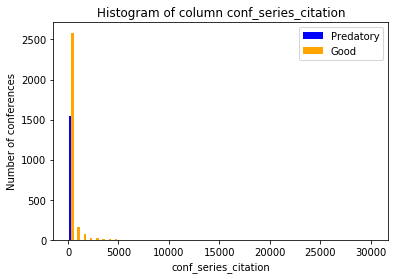

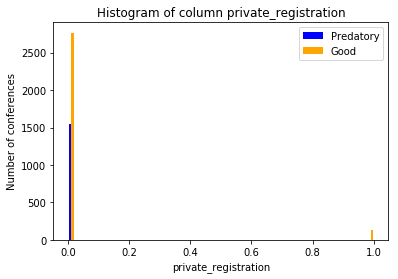

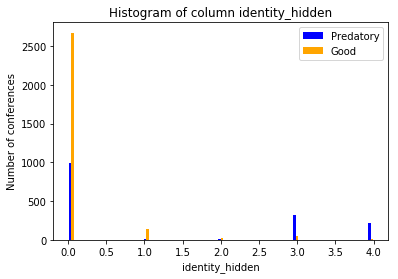

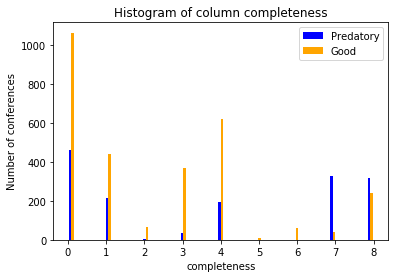

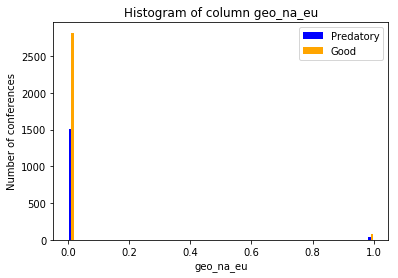

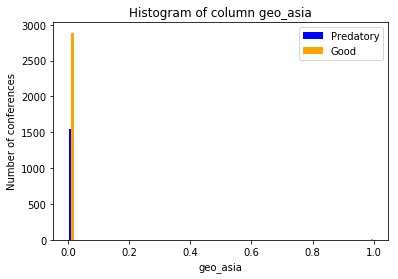

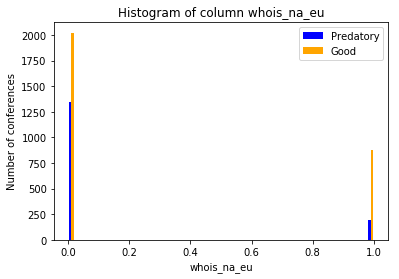

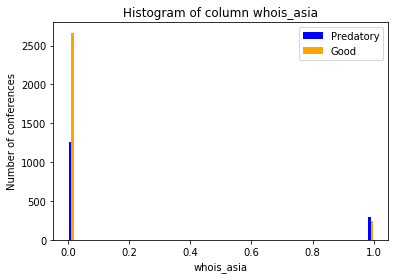

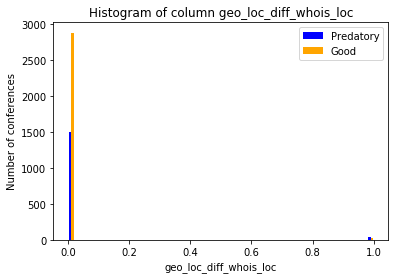

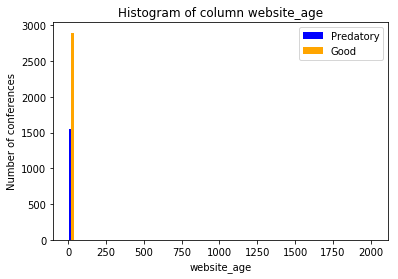

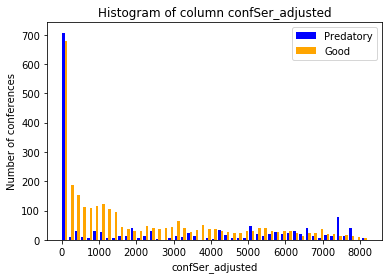

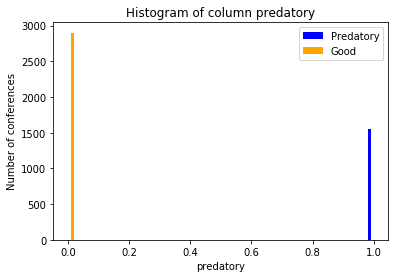

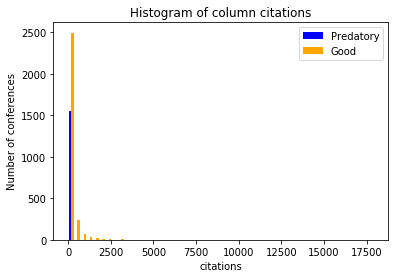

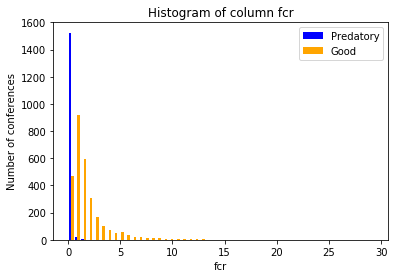

In [52]:
pyplt.style.use('seaborn-deep')

print(train.columns)
for column in train.columns:
    bins = np.linspace(train[column].min(), train[column].max(), 50)
    pyplt.hist([train_pred[column], train_good[column]], bins, label=['Predatory', 'Good'], color=['blue', 'orange'])
    pyplt.legend(loc='upper right')
    pyplt.xlabel(column)
    pyplt.ylabel('Number of conferences')
    pyplt.title('Histogram of column {}'.format(column))
    pyplt.show()

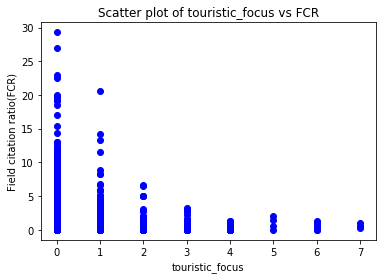

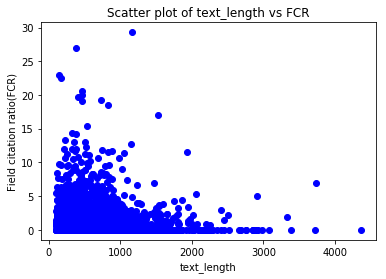

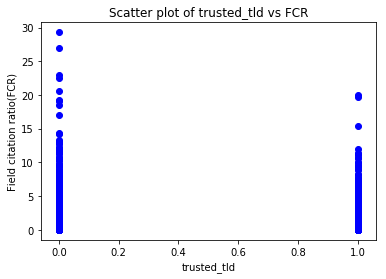

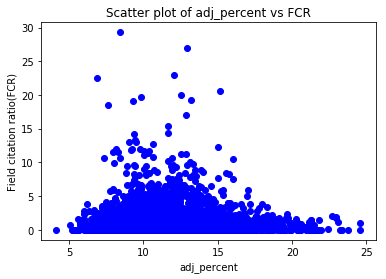

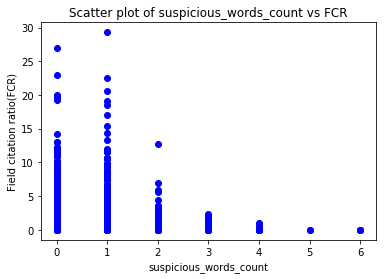

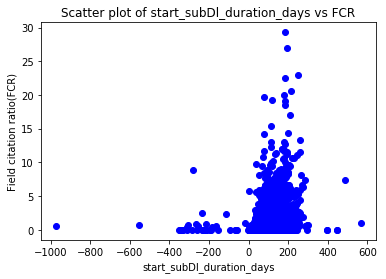

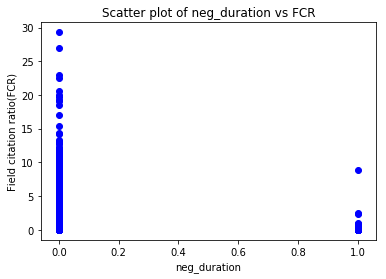

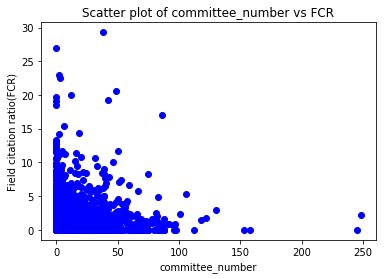

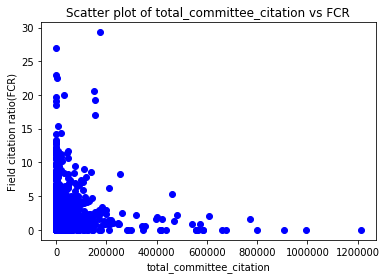

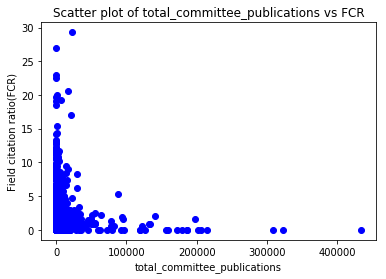

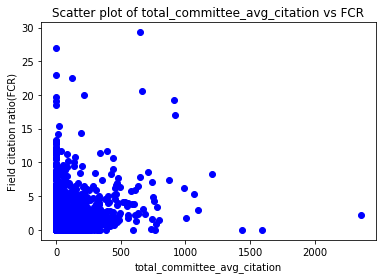

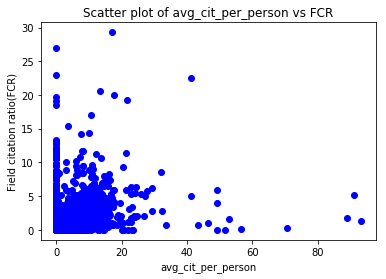

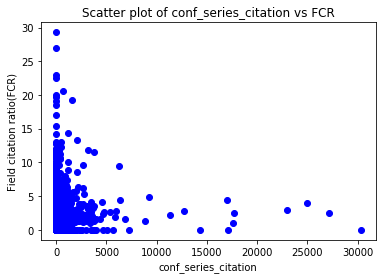

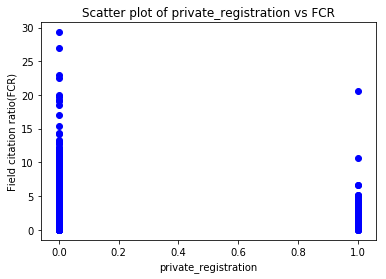

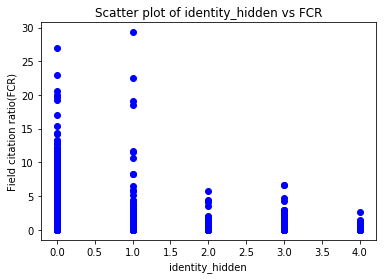

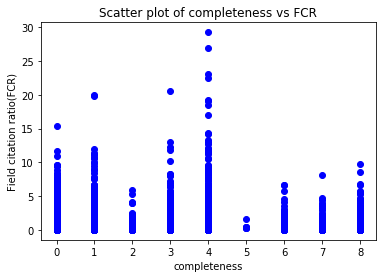

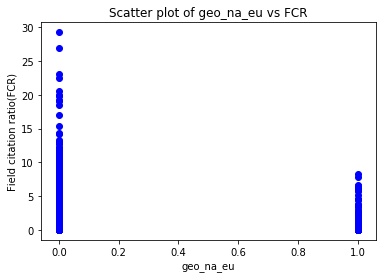

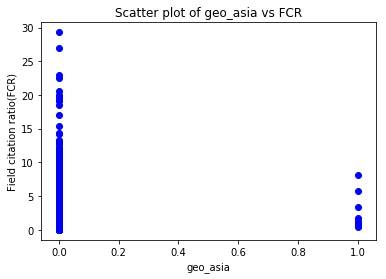

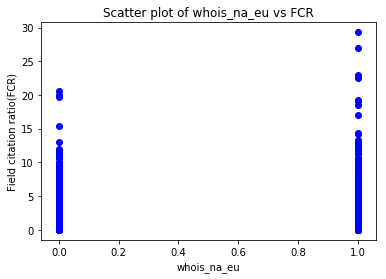

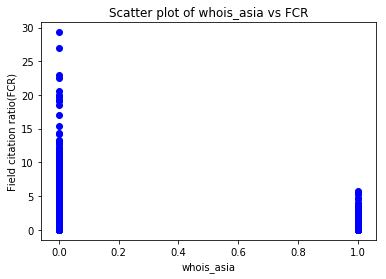

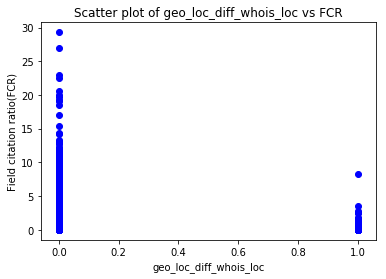

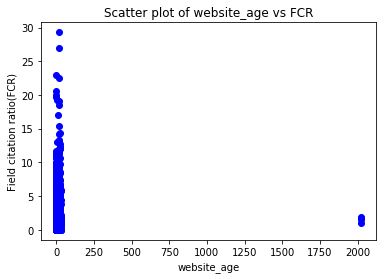

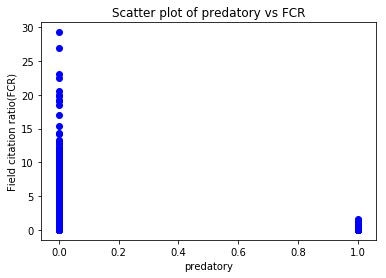

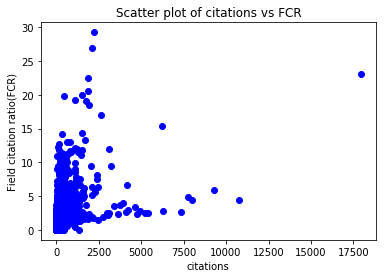

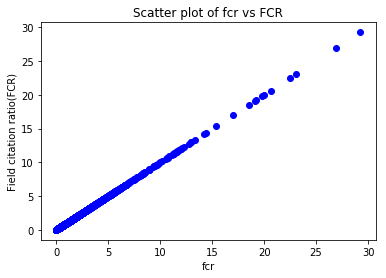

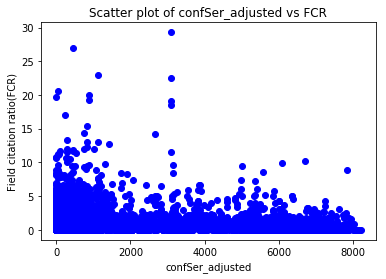

In [38]:
# Scatter plot of all features with target feature - Field citation ratio
for column in train.columns:    
    pyplt.scatter(train[column], train['fcr'], color=['blue'])
    pyplt.xlabel(column)
    pyplt.ylabel('Field citation ratio(FCR)')
    pyplt.title('Scatter plot of {} vs FCR'.format(column))
    pyplt.show()

In [39]:
# Correlation matrix of data features
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,touristic_focus,text_length,trusted_tld,adj_percent,suspicious_words_count,start_subDl_duration_days,neg_duration,committee_number,total_committee_citation,total_committee_publications,total_committee_avg_citation,avg_cit_per_person,conf_series_citation,private_registration,identity_hidden,completeness,geo_na_eu,geo_asia,whois_na_eu,whois_asia,website_age,predatory,citations,fcr,confSer_adjusted
touristic_focus,1,0.127093,0.0405375,0.00747955,0.065064,0.00794647,0.0263416,0.0781277,0.244375,0.260865,0.0632234,0.0507069,-0.0160669,-0.00614004,-0.0815633,0.00244149,0.0258749,-0.0089799,0.0267262,0.0465877,0.0118891,0.0413191,-0.0160043,-0.0477778,-0.0170956
text_length,0.127093,1,-0.0730879,0.0103429,0.0433829,0.0225575,0.0314869,0.483975,0.326034,0.288603,0.345358,0.128402,-0.00196053,-0.0496034,0.121357,0.158517,-0.0119937,-0.0313848,0.0294824,-0.0377876,0.0283981,0.148699,-0.0520573,-0.0342754,0.0463493
trusted_tld,0.0405375,-0.0730879,1,-0.0278493,-0.037732,0.0581829,-3.61447e-05,0.0433363,0.0184212,-0.00938393,0.096319,0.133266,-0.0165117,0.275241,-0.227168,-0.418242,0.0169616,0.0519015,-0.298118,-0.194694,-0.0350656,-0.272619,0.0184386,0.135084,-0.0301158
adj_percent,0.00747955,0.0103429,-0.0278493,1,-0.0193429,-0.00119241,-0.00918062,0.0212114,0.00257314,0.00225597,-0.00417204,-0.0413972,-0.0217669,0.0173508,0.0435706,0.0979214,-0.0306572,0.0152249,-0.0939566,0.105526,-0.00824449,0.0525305,-0.0161948,-0.0922161,0.04285
suspicious_words_count,0.065064,0.0433829,-0.037732,-0.0193429,1,-0.0346129,0.0369578,0.0703114,-0.00839783,0.000376615,-0.00933889,-0.0217367,0.0201234,-0.0201276,-0.162753,0.090253,-0.0190861,0.023857,0.0287099,0.122788,-0.0157874,0.0895525,0.0257155,-0.0285253,-0.0105502
start_subDl_duration_days,0.00794647,0.0225575,0.0581829,-0.00119241,-0.0346129,1,-0.486998,-0.00410493,0.0681675,0.0428817,0.097902,0.0965402,0.16726,0.0261543,-0.146365,-0.0567895,0.0345154,0.023028,0.158839,-0.202228,-0.0058038,-0.353002,0.242507,0.256099,-0.147833
neg_duration,0.0263416,0.0314869,-3.61447e-05,-0.00918062,0.0369578,-0.486998,1,0.0354611,-0.00431407,-0.000737069,-0.0056018,-0.0158987,-0.00600547,-0.0152287,-0.0274345,0.022761,0.00138222,-0.00460773,0.00773703,0.0425981,-0.00189228,0.0383404,-0.0190285,-0.0248911,0.017965
committee_number,0.0781277,0.483975,0.0433363,0.0212114,0.0703114,-0.00410493,0.0354611,1,0.530025,0.392095,0.791768,0.270072,0.0343597,-0.0109675,-0.118977,0.0328985,-0.0218236,-0.0102257,0.00716728,0.0967019,0.029089,-0.0739723,0.0245703,0.0985001,0.0263967
total_committee_citation,0.244375,0.326034,0.0184212,0.00257314,-0.00839783,0.0681675,-0.00431407,0.530025,1,0.951751,0.545163,0.225629,0.0278623,-0.0112774,-0.0741673,-0.0292503,0.00913781,-0.00817156,0.0556968,-0.0238713,0.101894,-0.0366997,0.0319453,0.0650286,-0.0495256
total_committee_publications,0.260865,0.288603,-0.00938393,0.00225597,0.000376615,0.0428817,-0.000737069,0.392095,0.951751,1,0.337953,0.11491,0.0081825,-0.0169142,-0.0562924,-0.0204654,0.0139636,-0.00702242,0.0405464,-0.012429,0.0832719,0.0185795,0.00495782,0.00114937,-0.0473944


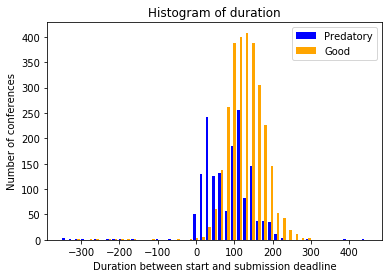

In [58]:
# Histogram plot for duration in case of predatory and non-predatory conferences
pyplt.style.use('seaborn-deep')


bins = np.linspace(train_pred['start_subDl_duration_days'].min(), train_pred['start_subDl_duration_days'].max(), 50)
pyplt.hist([train_pred['start_subDl_duration_days'], train_good['start_subDl_duration_days']], bins, label=['Predatory', 'Good'], color=['blue', 'orange'])
pyplt.legend(loc='upper right')
pyplt.xlabel('Duration between start and submission deadline')
pyplt.ylabel('Number of conferences')
pyplt.title('Histogram of duration')
#pyplt.show()
pyplt.savefig('duration_hist.png', bbox_inches = 'tight')

In [59]:
# Finding mean values of duration for predatory and good conferences
print(train_pred['start_subDl_duration_days'].mean())
print(train_good['start_subDl_duration_days'].mean())

82.15575810115885
128.30374712324465


In [60]:
# Finding mean values of Average citation of Program committee members
print(train_pred['total_committee_avg_citation'].mean())
print(train_good['total_committee_avg_citation'].mean())

11.477017628716023
52.449613884802396


In [63]:
# Finding predatory conferences with citation count > 0
train_pred_citations = train_pred[train_pred['citations'] > 0]
print(train_pred_citations.shape[0])

30
